<a href="https://colab.research.google.com/github/Ricardo-Jaramillo/Python-Tensorflow/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLim

The purpose of this notebook is to build an NLP model to make reading medical abstract easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

An reading through the paper above, we see that the model architecture that they use to achieve their best resulst is available here: https://arxiv.org/abs/1612.05251


In [ ]:
## Confirm access to a GPU
!nvidia-smi

Thu Sep 21 05:47:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the authors github: https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
 !git clone https://github.com/Franck-Dernoncourt/pubmed-rct
 !ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 17.63 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Check what files are in the PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
# !ls pubmed-rct/PubMed_20k_RCT/

dev.txt  test.txt  train.txt


In [ ]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir= '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [ ]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with the data is...

> Visualize, visualize, visualize

So with that in mind, let's write a function to read in all of the lines of a target text file.

In [ ]:
# Create function to read the lines of a document
def get_lines(filename):
  '''
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  '''
  with open(filename, 'r') as f:
    return f.readlines()

In [ ]:
# Let's read in the training lines
train_lines = get_lines(data_dir + 'train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

Let's think about how we want our data to look...

How I think our data would be best represented...

```[{ 'line_number': 0,
    'target': 'BACKGROUND',
    'text': "Emotional eating is associated with overeating and the development of obesity .\n",
    'total_lines': 11}],
    ...


In [ ]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string if the line is an ID line
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples


In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(filename=data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(filename=data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(filename=data_dir + 'test.txt')
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 700 ms, sys: 102 ms, total: 802 ms
Wall time: 1.15 s


In [ ]:
# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is the format of a list of dictionaries, how about we turn it into a DataFrame to further visualize it?

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

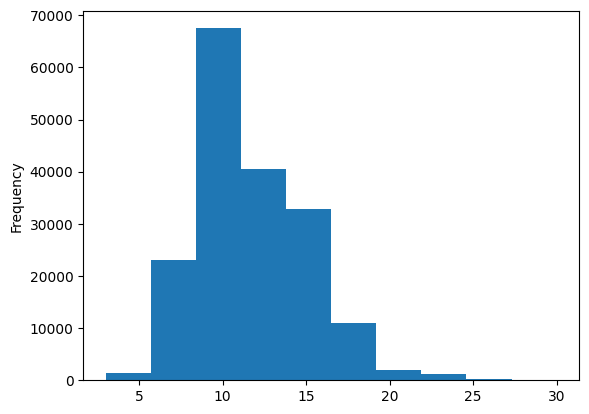

In [ ]:
# Let's check the length of different lines
train_df.total_lines.plot.hist()

### Get lists of sentences

In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Making numeric labels (ML models required numeric labels)

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # we want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1, 1))

# check what one hot encoded labels look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encoded labels

In [ ]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments...

As usual, we're going to be trying out a bunch of different models and seeing which one works best.

And as always, we're going to start with a baseline (TF-IDF Multinomial Naive Bayes classifier).

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
                 y=val_labels_encoded)

0.7218323844829869

In [ ]:
# Make some predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper functions script

In the previous module, we wrote a function to compare predictions across different metrics (accuracy, precision, recall and f1) and rather than rewriting it here, let's download it from our helper function script.

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-10-09 19:33:40--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-09 19:33:40 (103 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [ ]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

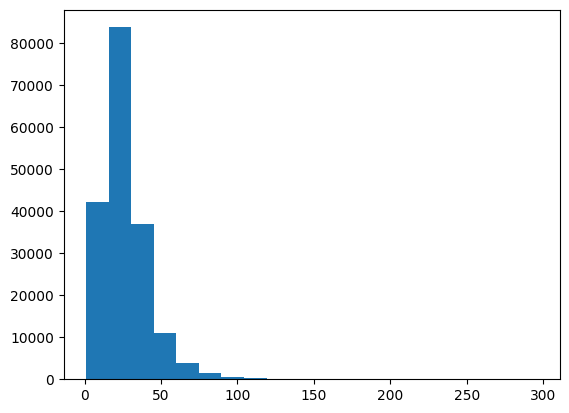

In [ ]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20)

In [ ]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer which maps our texts from words to numbers.

In [ ]:
# How many words are in our vocab? (taken from table 2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [ ]:
# Create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=output_seq_len) # desired output length of vectorized sequences

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test our text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f'Text:\n{target_sentence}')
print(f'\nLength of text: {len(target_sentence.split())}')
print(f'\nVectorized text: {text_vectorizer([target_sentence])}')

Text:
the mann-whitney u test was applied in order to find out the differences between groups , and to verify the existence of such differences , the friedman test for repeated measures complemented with multiple comparisons tests was carried out .

Length of text: 40

Vectorized text: [[    2  3279  1789   128    10   551     5   923     6  2825   508     2
    102    30    24     3     6  4735     2 10761     4   345   102     2
   9979   128    11   818   213 27058     7   466  1319   549    10  1076
    508     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocab: {len(rct_20k_text_vocab)}')
print(f'Most common words in the vocab: {rct_20k_text_vocab[:5]}')
print(f'Least common words in the vocab: {rct_20k_text_vocab[-5:]}')


Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

## Create custom text embedding

In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               mask_zero=True, # use masking to handle variable sequence lengthts (save space)
                               name='token_embedding')

In [ ]:
# Show example embedding
print(f'Sentence before vectorization:\n {target_sentence}\n')
vectorized_sentence = text_vectorizer([target_sentence])
print(f'Sentence after vectorization:\n {vectorized_sentence}\n')
embedded_sentence = token_embed(vectorized_sentence)
print(f'Sentence after embedding:\n {embedded_sentence}\n')
print(f'Embedded sentence shape: {embedded_sentence.shape}')

Sentence before vectorization:
 the mann-whitney u test was applied in order to find out the differences between groups , and to verify the existence of such differences , the friedman test for repeated measures complemented with multiple comparisons tests was carried out .

Sentence after vectorization:
 [[    2  3279  1789   128    10   551     5   923     6  2825   508     2
    102    30    24     3     6  4735     2 10761     4   345   102     2
   9979   128    11   818   213 27058     7   466  1319   549    10  1076
    508     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[-0.01755719 -0.03025841 -0.02138568 ... -0.01580112  0.02424127
    0.04063245]
  [ 0.01914037 -0.0431219   0.03330307 ...  0.00745615 -0.01014381
    0.01157845]
  [ 0.0166969  -0.03409803 -0.00015247 ...  0.04562009 -0.02195468
   -0.01187294]
  ...
  [ 0.0269429   0.03611204 -0.02457376 ... -0.04076458 -0.04124006
 

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are discussed at length in these two resources:
* https://www.tensorflow.org/guide/data_performance?hl=es-419
* https://www.tensorflow.org/api_docs/python/tf/data

In [ ]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_labels_one_hot.shape, train_labels_one_hot[0]

((180040, 5), array([0., 0., 0., 1., 0.]))

In [ ]:
# Take the TensorSliceDataset's and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [ ]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embeddings
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
len(train_dataset)

5627

In [ ]:
len(train_dataset) * 32

180064

In [ ]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 79s 139ms/step - loss: 0.9238 - accuracy: 0.6322 - val_loss: 0.6921 - val_accuracy: 0.7380
Epoch 2/3
562/562 [==============================] - 69s 123ms/step - loss: 0.6605 - accuracy: 0.7563 - val_loss: 0.6328 - val_accuracy: 0.7689
Epoch 3/3
562/562 [==============================] - 72s 129ms/step - loss: 0.6226 - accuracy: 0.7721 - val_loss: 0.6014 - val_accuracy: 0.7829


In [ ]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 7s 7ms/step - loss: 0.6031 - accuracy: 0.7832


[0.6030619144439697, 0.7831987142562866]

In [ ]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 6s 6ms/step


(array([[4.11685377e-01, 1.92773744e-01, 7.82497898e-02, 2.91907221e-01,
         2.53837500e-02],
        [4.69218522e-01, 2.62865871e-01, 9.53366607e-03, 2.52415806e-01,
         5.96615206e-03],
        [1.06059596e-01, 6.45626243e-03, 1.45980215e-03, 8.85989606e-01,
         3.47813875e-05],
        ...,
        [2.75176126e-06, 7.42919219e-04, 7.85403419e-04, 2.36962273e-06,
         9.98466611e-01],
        [4.73087691e-02, 4.13128972e-01, 1.00838982e-01, 6.18458875e-02,
         3.76877427e-01],
        [2.20795512e-01, 6.12540960e-01, 5.15216812e-02, 3.94255780e-02,
         7.57162943e-02]], dtype=float32),
 (30212, 5))

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Calulate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.31987289818615,
 'precision': 0.7796194312529964,
 'recall': 0.7831987289818615,
 'f1': 0.7806320087513938}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Feature extraction with pretrained token embeddings

Now let's use pretrained word embedding from TensorFlow Hub, more specifically the universal sentence encoder: "https://tfhub.dev/google/universal-sentence-encoder/4"

The paper originally used GloVe embeddings, however, we're hoing to stick with the later created USE pretrained embeddings.

In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name='universal_sentence_encoder')

In [ ]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f'Random sentence:\n{random_train_sentence}')
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f'Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n')
print(f'Length of sentence embedding: {len(use_embedded_sentence[0])}')

Random sentence:
independent evaluators assessed participants at baseline , week @ , week @ , week @ ( posttreatment ) , and week @ ( @-month follow-up ) .
Sentence after embedding:
[-0.02335067 -0.0399368  -0.05772385 -0.01786096 -0.04284175  0.05059479
  0.05868689 -0.04467102 -0.07746764  0.05731747 -0.01361405  0.02658206
 -0.02043407 -0.07617588 -0.02435373  0.01261192  0.00218196  0.05846574
  0.04792713  0.03120772 -0.01715097  0.07343798 -0.07179411  0.05238155
  0.01956189  0.04237754 -0.07776348 -0.06262928  0.00481705 -0.02742621]

Length of sentence embedding: 512


## Building and fitting an NLP feature extraction model using pretrained embeddings from TensorFlow Hub

In [ ]:
# Define feature extraction model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation='relu')(pretrained_embedding)
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(num_classes, activation='softmax')(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name='model_2_USE_feature_extractor')

# Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 15s 18ms/step - loss: 0.9168 - accuracy: 0.6494 - val_loss: 0.7969 - val_accuracy: 0.6902
Epoch 2/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7698 - accuracy: 0.7004 - val_loss: 0.7565 - val_accuracy: 0.7055
Epoch 3/3
562/562 [==============================] - 9s 17ms/step - loss: 0.7538 - accuracy: 0.7116 - val_loss: 0.7428 - val_accuracy: 0.7098


In [ ]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 12s 12ms/step - loss: 0.7436 - accuracy: 0.7132


[0.7436016798019409, 0.713193416595459]

In [ ]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 12s 13ms/step


array([[0.43014205, 0.35495773, 0.0021182 , 0.20463902, 0.00814294],
       [0.39904085, 0.4678766 , 0.00296543, 0.1272748 , 0.00284243],
       [0.20066175, 0.16079324, 0.01647159, 0.5811782 , 0.04089516],
       ...,
       [0.00231682, 0.00633047, 0.07013646, 0.00094316, 0.9202731 ],
       [0.00450315, 0.05151378, 0.18596499, 0.00142713, 0.7565909 ],
       [0.16367795, 0.25728053, 0.52835125, 0.00608429, 0.04460605]],
      dtype=float32)

In [ ]:
# Convert the prediction probabilities found with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# Calculate results from TF Hub pretrained embedding results on val set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.31934330729511,
 'precision': 0.7133254256268104,
 'recall': 0.7131934330729511,
 'f1': 0.7099063693896375}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
model_1_results

{'accuracy': 78.31987289818615,
 'precision': 0.7796194312529964,
 'recall': 0.7831987289818615,
 'f1': 0.7806320087513938}

## Model 3: Conv1D with character embeddings

The paper which we're replicating states they used a combination of token and character-level embeddings.

Previously we've token-level embeddings but we'll need to do similar steps for character if we want to use char-level embeddings.

## Creating a character-level tokenizer

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return ' '.join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

'i n d e p e n d e n t   e v a l u a t o r s   a s s e s s e d   p a r t i c i p a n t s   a t   b a s e l i n e   ,   w e e k   @   ,   w e e k   @   ,   w e e k   @   (   p o s t t r e a t m e n t   )   ,   a n d   w e e k   @   (   @ - m o n t h   f o l l o w - u p   )   .'

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([9.2691e+04, 7.6343e+04, 9.6890e+03, 1.0890e+03, 1.6700e+02,
        4.2000e+01, 1.3000e+01, 3.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 1.3950e+02, 2.7800e+02, 4.1650e+02, 5.5500e+02,
        6.9350e+02, 8.3200e+02, 9.7050e+02, 1.1090e+03, 1.2475e+03,
        1.3860e+03]),
 <BarContainer object of 10 artists>)

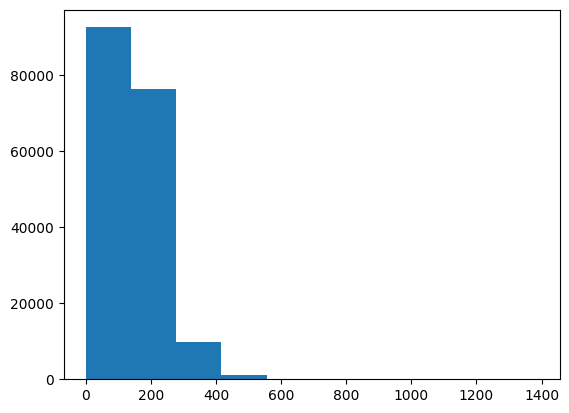

In [ ]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=10)

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard character
random.choice(train_sentences)

'the pvri , however , was significantly lower in the pulsatile perfusion group @ mins after the administration of protamine ( p < @ ) .'

In [ ]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, '[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    # standardize=None, # set standardization to "None" if you want to leave punctuation
                                    name='char_vectorizer')

In [ ]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different charachers in character vocab: {len(char_vocab)}')
print(f'5 most common characters: {char_vocab[:5]}')
print(f'5 least common characters: {char_vocab[-5:]}')

Number of different charachers in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
random_train_sentence

'independent evaluators assessed participants at baseline , week @ , week @ , week @ ( posttreatment ) , and week @ ( @-month follow-up ) .'

In [ ]:
# Test our character vectorizer
random_train_chars = random.choice(train_chars)
print(f'Charified text:\n {random_train_chars}')
print(f'Length of random_train_chars: {len(random_train_chars.split())}')
vectorized_chars = char_vectorizer([random_train_chars])
print(f'\Vectorized chars:\n {vectorized_chars}')
print(f'\nLength of vectorized chars: {len(vectorized_chars[0])}')

Charified text:
 i n   t h e   i n t e r n a t i o n a l   r a n d o m i s e d   p h a s e   @   c o r r e c t   t r i a l   (   n c t @   )   ,   r e g o r a f e n i b   s i g n i f i c a n t l y   i m p r o v e d   o v e r a l l   s u r v i v a l   v e r s u s   p l a c e b o   i n   p a t i e n t s   w i t h   t r e a t m e n t - r e f r a c t o r y   m e t a s t a t i c   c o l o r e c t a l   c a n c e r   .
Length of random_train_chars: 174
\Vectorized chars:
 [[ 4  6  3 13  2  4  6  3  2  8  6  5  3  4  7  6  5 12  8  5  6 10  7 15
   4  9  2 10 14 13  5  9  2 11  7  8  8  2 11  3  3  8  4  5 12  6 11  3
   8  2 18  7  8  5 17  2  6  4 22  9  4 18  6  4 17  4 11  5  6  3 12 19
   4 15 14  8  7 21  2 10  7 21  2  8  5 12 12  9 16  8 21  4 21  5 12 21
   2  8  9 16  9 14 12  5 11  2 22  7  4  6 14  5  3  4  2  6  3  9 20  4
   3 13  3  8  2  5  3 15  2  6  3  8  2 17  8  5 11  3  7  8 19 15  2  3
   5  9  3  5  3  4 11 11  7 12  7  8  2 11  3  5 12 11  5  6 11  2  8  0
   0  0  0 

## Creating a character-level embedding

In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # this is the size of the char embedding in the paper: https://arxiv.org/pdf/1710.06071.pdf
                              mask_zero=True,
                              name='char_embed')

In [ ]:
# Test our character embedding layer
print(f'Charified text:\n {random_train_chars}\n')
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f'Embedded chars (after vectorization and embedding):\n {char_embed_example}')
print(f'Character embedding shape: {char_embed_example.shape}')

Charified text:
 i n   t h e   i n t e r n a t i o n a l   r a n d o m i s e d   p h a s e   @   c o r r e c t   t r i a l   (   n c t @   )   ,   r e g o r a f e n i b   s i g n i f i c a n t l y   i m p r o v e d   o v e r a l l   s u r v i v a l   v e r s u s   p l a c e b o   i n   p a t i e n t s   w i t h   t r e a t m e n t - r e f r a c t o r y   m e t a s t a t i c   c o l o r e c t a l   c a n c e r   .

Embedded chars (after vectorization and embedding):
 [[[-0.02797624 -0.03361802  0.00371281 ...  0.03232694  0.03851903
   -0.01051132]
  [-0.00522468  0.03394953  0.02493805 ... -0.01643918 -0.0245609
    0.03746361]
  [ 0.04140325  0.01131956  0.03337878 ... -0.04141903 -0.04751071
    0.00116955]
  ...
  [ 0.01233793  0.04446044  0.02794306 ... -0.00537763 -0.03193384
   -0.01690898]
  [ 0.01233793  0.04446044  0.02794306 ... -0.00537763 -0.03193384
   -0.01690898]
  [ 0.01233793  0.04446044  0.02794306 ... -0.00537763 -0.03193384
   -0.01690898]]]
Character embedding shap

### Building a Conv1D model to fit on character embeddings

In [ ]:
# Make a Conv1D on chars only
inputs= layers.Input(shape=(1,), dtype='string')
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name='model_3_conv1d_char_embeddings')

# Compile
model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Summary
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 

In [ ]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 14s 24ms/step - loss: 1.2702 - accuracy: 0.4852 - val_loss: 1.0435 - val_accuracy: 0.5878
Epoch 2/3
562/562 [==============================] - 16s 28ms/step - loss: 1.0063 - accuracy: 0.5925 - val_loss: 0.9417 - val_accuracy: 0.6237
Epoch 3/3
562/562 [==============================] - 25s 45ms/step - loss: 0.9299 - accuracy: 0.6347 - val_loss: 0.8740 - val_accuracy: 0.6609


In [ ]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 7s 7ms/step


array([[0.23646373, 0.36306843, 0.06378975, 0.2860111 , 0.05066704],
       [0.15154229, 0.63016367, 0.01642384, 0.11080914, 0.09106103],
       [0.11418646, 0.22432601, 0.12921925, 0.4741217 , 0.0581465 ],
       ...,
       [0.02509472, 0.06495669, 0.13464896, 0.05361231, 0.7216874 ],
       [0.02590032, 0.10953818, 0.5108875 , 0.04546477, 0.3082093 ],
       [0.45819962, 0.37583643, 0.08088752, 0.05768115, 0.02739528]],
      dtype=float32)

In [ ]:
# Conver prediction probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 2, 0])>

In [ ]:
# Calculate results for Conv1D model chars only
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 65.16284919899378,
 'precision': 0.6465127291963878,
 'recall': 0.6516284919899378,
 'f1': 0.6423236350378837}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
model_2_results

{'accuracy': 71.31934330729511,
 'precision': 0.7133254256268104,
 'recall': 0.7131934330729511,
 'f1': 0.7099063693896375}

In [ ]:
model_1_results

{'accuracy': 78.31987289818615,
 'precision': 0.7796194312529964,
 'recall': 0.7831987289818615,
 'f1': 0.7806320087513938}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

1. Create a token-level embedding model (similar `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of input layers on top of 3 similar to Figure 1 and section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Setup char inputs/Model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout, discussed in section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name='model_4_token_and_char_embeddings')

In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

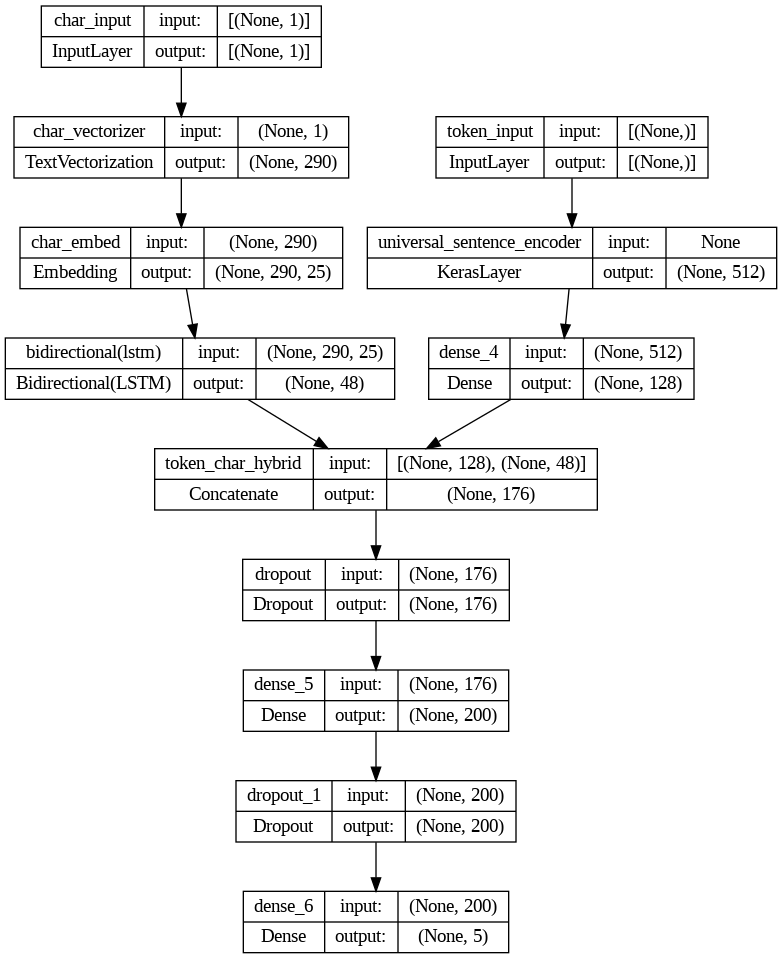

In [ ]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
# Compile token char model
model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of the paper says they use SGD, you might want to try this
                metrics=['accuracy'])

### Combining token and character data into a tf.data Dataset

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Repeat the above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data and labels

# Prefetch and batch val data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [ ]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(train_char_dataset)))

Epoch 1/3
562/562 [==============================] - 240s 407ms/step - loss: 0.9678 - accuracy: 0.6154 - val_loss: 0.7701 - val_accuracy: 0.7040
Epoch 2/3
562/562 [==============================] - 224s 398ms/step - loss: 0.7915 - accuracy: 0.6985 - val_loss: 0.7091 - val_accuracy: 0.7300
Epoch 3/3
562/562 [==============================] - 225s 401ms/step - loss: 0.7664 - accuracy: 0.7093 - val_loss: 0.6859 - val_accuracy: 0.7398


In [ ]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 66s 70ms/step - loss: 0.6920 - accuracy: 0.7379


[0.6919814348220825, 0.7379187345504761]

In [ ]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 75s 75ms/step


array([[3.6688578e-01, 4.4472083e-01, 3.9016700e-03, 1.7580551e-01,
        8.6861197e-03],
       [3.0663651e-01, 5.3275716e-01, 3.8165974e-03, 1.5430057e-01,
        2.4890390e-03],
       [2.5809920e-01, 9.6171044e-02, 4.6821240e-02, 5.7574236e-01,
        2.3166211e-02],
       ...,
       [4.8611697e-04, 6.8041408e-03, 6.1391681e-02, 2.2940683e-04,
        9.3108869e-01],
       [7.0456481e-03, 5.7825502e-02, 3.1719720e-01, 2.7303067e-03,
        6.1520141e-01],
       [2.5091740e-01, 4.2556280e-01, 2.5162739e-01, 2.8460395e-02,
        4.3431979e-02]], dtype=float32)

In [ ]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [ ]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.79187077982259,
 'precision': 0.7405986495541127,
 'recall': 0.7379187077982259,
 'f1': 0.7341730116488934}

In [ ]:
model_1_results

{'accuracy': 78.31987289818615,
 'precision': 0.7796194312529964,
 'recall': 0.7831987289818615,
 'f1': 0.7806320087513938}

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> 🔑 **Note:** Any engineered feature used to train a model need to be available at test time.

### Create positional embeddings

In [ ]:
# How many different line numbers are there?
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

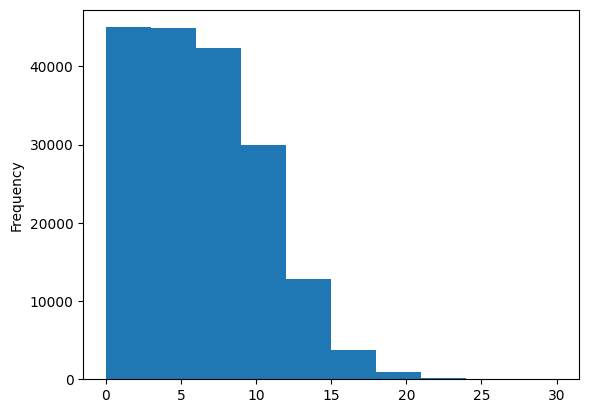

In [ ]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [ ]:
# Use TensorFlow to create one hot-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

Now we've encoded our line numbers feature, let's do the same for our total lines feature...

In [ ]:
# How many different numbers of lines are there?
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

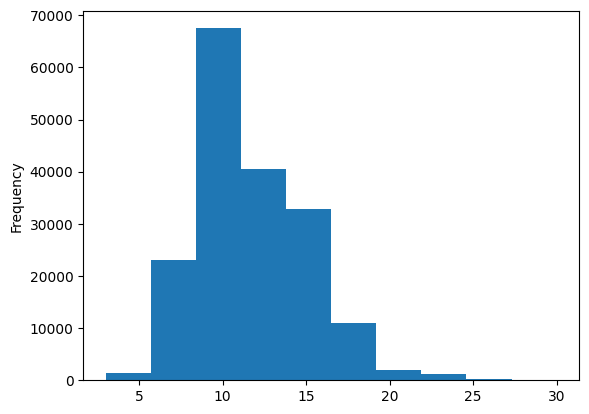

In [ ]:
# Check the distribution of total lines
train_df.total_lines.plot.hist()

In [ ]:
# Check the coverage of a 'total_lines' value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [ ]:
# Use TensorFlow to create one-hot encoded tensors of our 'total_lines' feature
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the 'line_number' feature
4. Create a model for the 'total_lines' feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribried embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a tf.keras.Model

In [ ]:
train_line_numbers_one_hot[0].shape

TensorShape([15])

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype='string', name='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1, ), dtype='string', name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name='line_number_input')
x = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20, ), dtype=tf.float32, name='total_lines_inputs')
y = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

# 5. Combine token char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name='char_token_hybrid_embedding')([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name='char_token_positional_embedding')([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])

# 7- Create output layer
output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                total_lines_model.input,
                                token_model.input,
                                char_model.input],
                         outputs=output_layer,
                         name='model_5_tribrid_embedding_model')

In [ ]:
# Get a summary of our tribrid model
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   

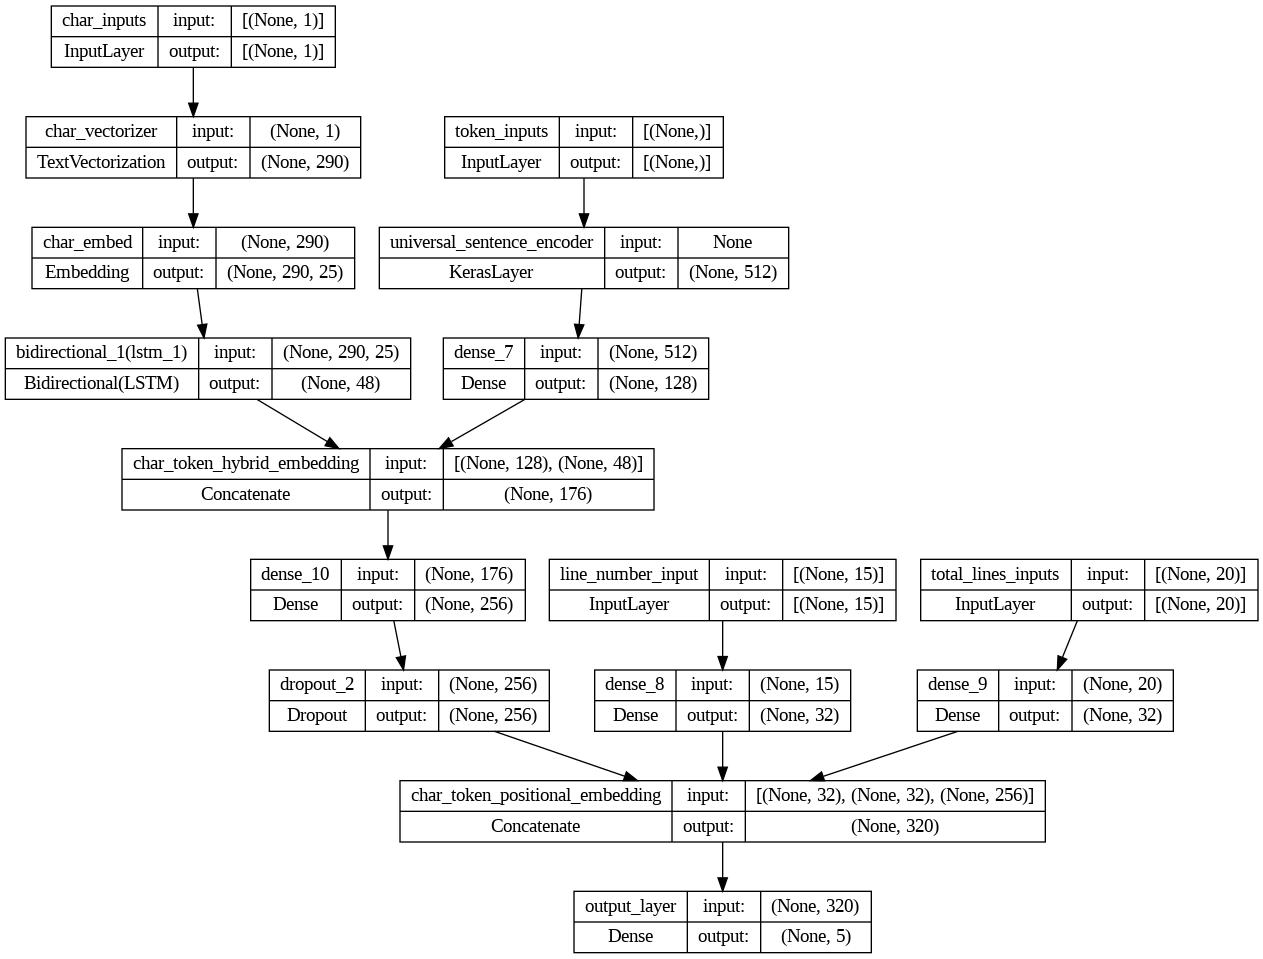

In [ ]:
# Plot model 5 to explore it visually...
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

What is label smoothing?

For example if, our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not consider other classes...

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smothing does is it assigns some of the value from the highest pred prob to other classes, in turn, hopefully improving generalization: `[0.01, 0.01, 0.96, 0.01, 0.01]`

> 📖 **Resource:** For more on label smoothing, see the great blog post by PyImageSearch, Label smoothing with Keras, TensorFlow, and Deep Learning: https://pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

In [ ]:
# Compile token, char, and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

### Create tribrid embedding datasets using tf.data

In [ ]:
# Create training and validation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for the validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

## Fitting, evaluating and making predictions with our tribrid model

In [ ]:
# Fit our tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 227s 372ms/step - loss: 1.0971 - accuracy: 0.7234 - val_loss: 0.9797 - val_accuracy: 0.8075
Epoch 2/3
562/562 [==============================] - 191s 339ms/step - loss: 0.9686 - accuracy: 0.8153 - val_loss: 0.9505 - val_accuracy: 0.8241
Epoch 3/3
562/562 [==============================] - 191s 339ms/step - loss: 0.9516 - accuracy: 0.8202 - val_loss: 0.9398 - val_accuracy: 0.8295


In [ ]:
# Make predictions with the char token pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 73s 72ms/step


array([[0.49220118, 0.12437952, 0.00982229, 0.35564288, 0.01795422],
       [0.54482293, 0.10984971, 0.03638751, 0.2998348 , 0.00910507],
       [0.30266702, 0.113098  , 0.13090762, 0.3830073 , 0.07032003],
       ...,
       [0.03428521, 0.1249045 , 0.03882666, 0.03144687, 0.7705368 ],
       [0.02663895, 0.30254397, 0.07193851, 0.02299599, 0.57588255],
       [0.20742223, 0.60664946, 0.0808707 , 0.04757841, 0.05747927]],
      dtype=float32)

In [ ]:
# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs,axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate results of char token pos model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.36422613531047,
 'precision': 0.8325482346252152,
 'recall': 0.8336422613531047,
 'f1': 0.8325869281669683}

In [ ]:
model_4_results

{'accuracy': 73.79187077982259,
 'precision': 0.7405986495541127,
 'recall': 0.7379187077982259,
 'f1': 0.7341730116488934}

In [ ]:
model_1_results

{'accuracy': 78.31987289818615,
 'precision': 0.7796194312529964,
 'recall': 0.7831987289818615,
 'f1': 0.7806320087513938}

## Compare model results

In [ ]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({'model_0_baseline': baseline_results,
                                  'model_1_custom_token_embedding': model_1_results,
                                  'model_2_pretrained_token_embedding': model_2_results,
                                  'model_3_custom_char_embedding': model_3_results,
                                  'model_4_hybrid_char_token_embedding': model_4_results,
                                  'model_5_pos_char_token_embedding': model_5_results}).transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.319873,0.779619,0.783199,0.780632
model_2_pretrained_token_embedding,71.319343,0.713325,0.713193,0.709906
model_3_custom_char_embedding,65.162849,0.646513,0.651628,0.642324
model_4_hybrid_char_token_embedding,73.791871,0.740599,0.737919,0.734173
model_5_pos_char_token_embedding,83.364226,0.832548,0.833642,0.832587


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results['accuracy'] = all_model_results['accuracy'] / 100
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,0.721832,0.718647,0.721832,0.698925
model_1_custom_token_embedding,0.783199,0.779619,0.783199,0.780632
model_2_pretrained_token_embedding,0.713193,0.713325,0.713193,0.709906
model_3_custom_char_embedding,0.651628,0.646513,0.651628,0.642324
model_4_hybrid_char_token_embedding,0.737919,0.740599,0.737919,0.734173
model_5_pos_char_token_embedding,0.833642,0.832548,0.833642,0.832587


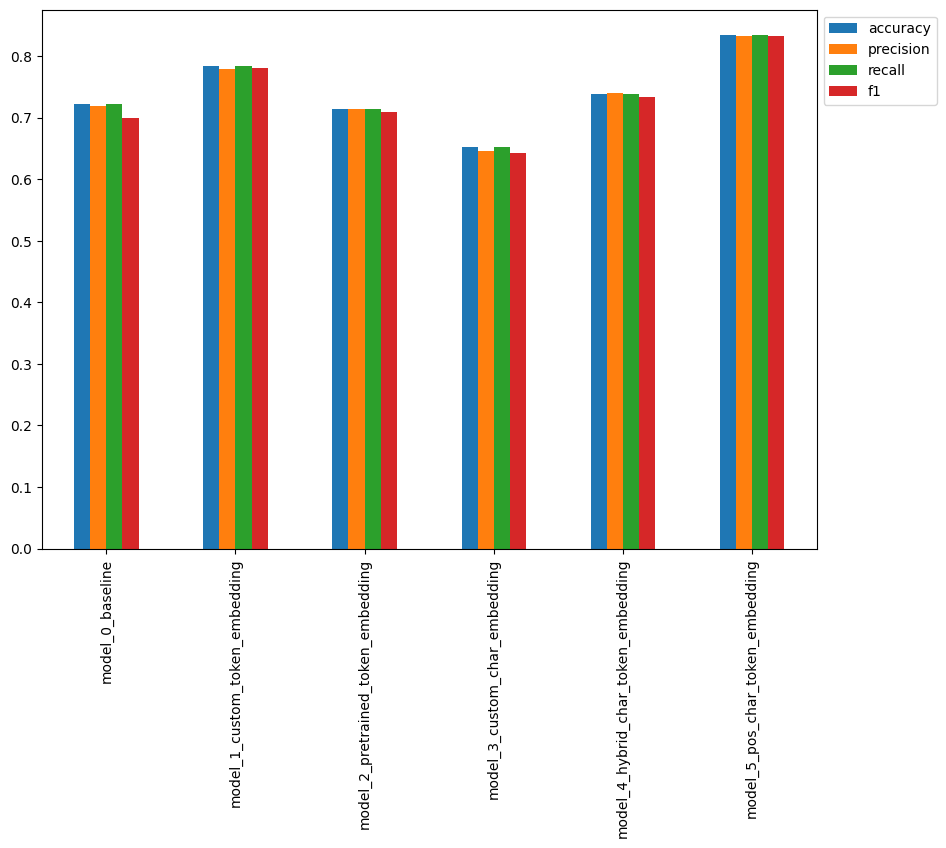

In [ ]:
# Plot and compare all model results
all_model_results.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

<Axes: >

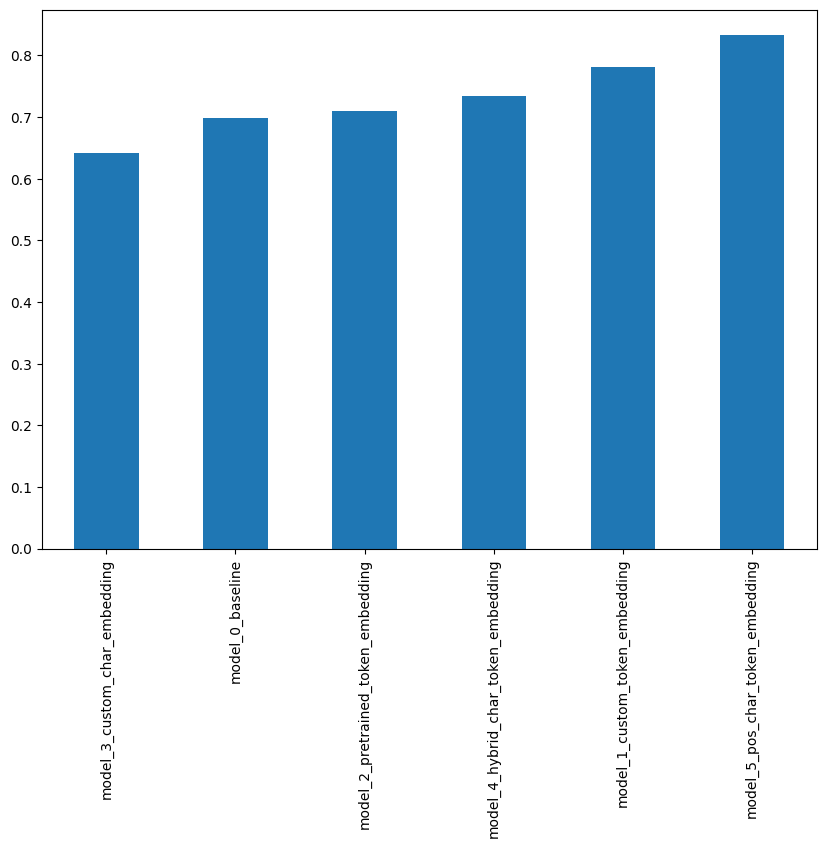

In [ ]:
# Sort models results by f1-score
all_model_results.sort_values('f1', ascending=True)['f1'].plot(kind='bar', figsize=(10, 7))

## Save and load model

In [ ]:
# Save the best performing model to SavedModel format (default)
model_5.save('skimlit_tribrid_model')

In [ ]:
# Load in best performing model
loaded_model = tf.keras.models.load_model('skimlit_tribrid_model')

In [ ]:
# Make predictions with the loaded model on the validation set
loaded_model_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_model_preds = tf.argmax(loaded_model_pred_probs, axis=1)
loaded_model_preds[:10]

945/945 [==============================] - 77s 78ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
# Calculate the results of our loaded model
loaded_model_results = calculate_results(y_true=val_labels_encoded,
                                         y_pred=loaded_model_preds)
loaded_model_results

{'accuracy': 83.36422613531047,
 'precision': 0.8325482346252152,
 'recall': 0.8336422613531047,
 'f1': 0.8325869281669683}

In [ ]:
model_5_results

{'accuracy': 83.36422613531047,
 'precision': 0.8325482346252152,
 'recall': 0.8336422613531047,
 'f1': 0.8325869281669683}

In [ ]:
assert model_5_results == loaded_model_results

In [ ]:
# Check the loaded model summary
loaded_model.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   

In [ ]:
# Download and load in a pretrained model from Google Storage
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import TextVectorization

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2023-10-09 17:43:42--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.148.207, 209.85.200.207, 209.85.234.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.148.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962182847 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.61M  37.9MB/s    in 17s     

2023-10-09 17:44:00 (53.1 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962182847/962182847]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
  inflating: skimlit_gs_model/skimlit_tribrid_model/keras_metadata.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/assets/
 extracting: skimlit_gs_model/skimlit_tribrid_model/fingerprint.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/

In [ ]:
# Load in downloaded Google Storage model
loaded_gs_model = tf.keras.models.load_model('skimlit_gs_model/skimlit_tribrid_model/')

In [ ]:
# Evaluate the loaded Google Storage model
loaded_gs_model.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 62s 64ms/step - loss: 0.9388 - accuracy: 0.8303


[0.9387755990028381, 0.830332338809967]

## Your challenges

1. Turn the best data samples into a tf.data Dataset (fast loading) and then evaluate (make predictions) the best performing model on the test samples.
2. Find the most wrong predictions from 1 (these are the samples where the model has predicted the wrong label with the highest prediction probability).
3. Make example predictions (on RCT abstract from the wild), you can go to PubMed to find these: https://pubmed.ncbi.nlm.nih.gov/, find and use our model to predict on 3-4 different abstracts from the wild.
  * Some examples: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/skimlit_example_abstracts.json
  4. See the exercises and extra curriculum section on GitHub to further test your skills (for section 09)

### 1. Turn the best data samples into a tf.data Dataset (fast loading) and then evaluate (make predictions) the best performing model on the test samples.

In [ ]:
# Prepare data
test_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8


In [ ]:
# Make a test dataset
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                                test_total_lines_one_hot,
                                                                test_sentences,
                                                                test_chars))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_labels))
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Make predictions on model 5 or loaded_gs_model
test_prob_preds_model_5 = model_5.predict(test_char_token_pos_dataset)
test_preds_model_5 = tf.argmax(test_prob_preds_model_5, axis=1)
test_preds_model_5[:10]

942/942 [==============================] - 102s 108ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 2, 2, 4, 4, 4, 1, 4, 0])>

In [ ]:
# Calculate the results with our test data
model_5_test_results = calculate_results(y_true=test_labels_encoded,
                                         y_pred=test_preds_model_5)
model_5_test_results

{'accuracy': 82.81400365024058,
 'precision': 0.8268914815299824,
 'recall': 0.8281400365024059,
 'f1': 0.8270259180777895}

### 2. Find the most wrong predictions from 1 (these are the samples where the model has predicted the wrong label with the highest prediction probability).

In [ ]:
# Copy the original test_df
test_df_with_preds = test_df[['target', 'text']].copy()
test_df_with_preds.head()

,target,text
0,BACKGROUND,this study analyzed liver function abnormaliti...
1,RESULTS,a post hoc analysis was conducted with the use...
2,RESULTS,liver function tests ( lfts ) were measured at...
3,RESULTS,survival analyses were used to assess the asso...
4,RESULTS,the percentage of patients with abnormal lfts ...


In [ ]:
test_df_with_preds['pred'] = [class_names[pred] for pred in test_preds_model_5]
test_df_with_preds['prob'] = tf.reduce_max(test_prob_preds_model_5, axis=1).numpy()
test_df_with_preds['result'] = test_df_with_preds['target'] == test_df_with_preds['pred']
test_df_with_preds.head()

,target,text,pred,prob,result
0,BACKGROUND,this study analyzed liver function abnormaliti...,OBJECTIVE,0.493171,False
1,RESULTS,a post hoc analysis was conducted with the use...,BACKGROUND,0.323210,False
2,RESULTS,liver function tests ( lfts ) were measured at...,METHODS,0.794350,False
3,RESULTS,survival analyses were used to assess the asso...,METHODS,0.643698,False
4,RESULTS,the percentage of patients with abnormal lfts ...,RESULTS,0.739932,True


In [ ]:
# Save most 100 wrong
top_100_wrong = test_df_with_preds[test_df_with_preds['result'] == False].sort_values('prob', ascending=False)
top_100_wrong.head()

,target,text,pred,prob,result
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,METHODS,0.949176,False
16633,CONCLUSIONS,clinicaltrials.gov identifier : nct@ .,BACKGROUND,0.939091,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,METHODS,0.931647,False
1827,CONCLUSIONS,nct@ ( clinicaltrials.gov ) .,BACKGROUND,0.929137,False
3573,RESULTS,a cluster randomised trial was implemented wit...,METHODS,0.927258,False


<Axes: >

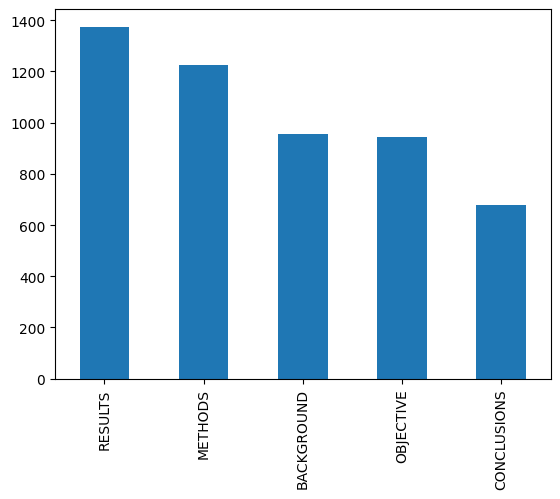

In [ ]:
# Plot
top_100_wrong.target.value_counts().plot.bar()

In [ ]:
# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9491758346557617

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: CONCLUSIONS, Pred: BACKGROUND, Prob: 0.9390907287597656

Text:
clinicaltrials.gov identifier : nct@ .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9316470623016357

Text:
the primary endpoint is the cumulative three-year hiv incidence .

-----

Target: CONCLUSIONS, Pred: BACKGROUND, Prob: 0.9291366934776306

Text:
nct@ ( clinicaltrials.gov ) .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9272583723068237

Text:
a cluster randomised trial was implemented with @,@ children in @ government primary schools on the south coast of kenya in @-@ .

-----

Target: METHODS, Pred: BACKGROUND, Prob: 0.9271798729896545

Text:
pretest-posttest .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9203554391860962

Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

-----

Target

### 3. Make example predictions (on RCT abstract from the wild), you can go to PubMed to find these: https://pubmed.ncbi.nlm.nih.gov/, find and use our model to predict on 3-4 different abstracts from the wild.
  * Some examples: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/skimlit_example_abstracts.json
  4. See the exercises and extra curriculum section on GitHub to further test your skills (for section 09)

## 🛠 Exercises

1. Train `model_5` on all of the data in the training dataset for as many epochs until it stops improving. Since this might take a while, you might want to use:
  * [`tf.keras.callbacks.ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) to save the model's best weights only.
  * [`tf.keras.callbacks.EarlyStopping`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) to stop the model from training once the validation loss has stopped improving for ~3 epochs.
2. Checkout the [Keras guide on using pretrained GloVe embeddings](https://keras.io/examples/nlp/pretrained_word_embeddings/). Can you get this working with one of our models?
  * Hint: You'll want to incorporate it with a custom token [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer.
  * It's up to you whether or not you fine-tune the GloVe embeddings or leave them frozen.
3. Try replacing the TensorFlow Hub Universal Sentence Encoder pretrained  embedding for the [TensorFlow Hub BERT PubMed expert](https://tfhub.dev/google/experts/bert/pubmed/2) (a language model pretrained on PubMed texts) pretrained embedding. Does this effect results?
  * Note: Using the BERT PubMed expert pretrained embedding requires an extra preprocessing step for sequences (as detailed in the [TensorFlow Hub guide](https://tfhub.dev/google/experts/bert/pubmed/2)).
  * Does the BERT model beat the results mentioned in this paper? https://arxiv.org/pdf/1710.06071.pdf
4. What happens if you were to merge our `line_number` and `total_lines` features for each sequence? For example, created a `X_of_Y` feature instead? Does this effect model performance?
  * Another example: `line_number=1` and `total_lines=11` turns into `line_of_X=1_of_11`.
5. Write a function (or series of functions) to take a sample abstract string, preprocess it (in the same way our model has been trained), make a prediction on each sequence in the abstract and return the abstract in the format:
  * `PREDICTED_LABEL`: `SEQUENCE`
  * `PREDICTED_LABEL`: `SEQUENCE`
  * `PREDICTED_LABEL`: `SEQUENCE`
  * `PREDICTED_LABEL`: `SEQUENCE`
  * ...
    * You can find your own unstrcutured RCT abstract from PubMed or try this one from: [*Baclofen promotes alcohol abstinence in alcohol dependent cirrhotic patients with hepatitis C virus (HCV) infection*](https://pubmed.ncbi.nlm.nih.gov/22244707/).

## 📖 Extra-curriculum
* For more on working with text/spaCy, see [spaCy's advanced NLP course](https://course.spacy.io/en/). If you're going to be working on production-level NLP problems, you'll probably end up using spaCy.
* For another look at how to approach a text classification problem like the one we've just gone through, I'd suggest going through [Google's Machine Learning Course for text classification](https://developers.google.com/machine-learning/guides/text-classification).
* Since our dataset has imbalanced classes (as with many real-world datasets), so it might be worth looking into the [TensorFlow guide for different methods to training a model with imbalanced classes](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data).
